In [1]:
from langgraph.graph import StateGraph, MessagesState, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.runnables import RunnableConfig
from dotenv import load_dotenv
load_dotenv("../../config/local.env")

c:\Users\ytiam\notebooks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ytiam\notebooks\.venv\Lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find cuobjdump.exe
  warnings.warn(f"Failed to find {binary}")
c:\Users\ytiam\notebooks\.venv\Lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find nvdisasm.exe
  warnings.warn(f"Failed to find {binary}")


True

In [2]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [3]:
class CustomMessagesState(MessagesState):
    topic: str
    draft: str
    feedback: str
    score: int


import re

def extract_numerator(feedback: str, default: int = 7) -> int:
    """
    Extracts the first integer before a slash (/) in the given feedback string.
    Returns `default` if no such pattern is found.
    """
    match = re.search(r'\b(\d+)(?=\s*/)', feedback)
    return int(match.group(1)) if match else default

In [4]:
extract_numerator("My name is Atanu and I have received a score of 8/10, well done")  # Should return 8

8

In [5]:
custom_recursion_limit = 5

# Create a RunnableConfig object with the specified recursion limit
config = RunnableConfig(recursion_limit=custom_recursion_limit)

In [10]:

# 1️⃣ Writer Agent – produces a first draft
def writer_node(state: CustomMessagesState):
    system_prompt = SystemMessage("Write a short explanation about the given topic.\n\n")
    response = llm.invoke([system_prompt, HumanMessage(content= state["topic"])])
    return {"draft": response.content, "topic": state["topic"]}

# 2️⃣ Evaluator Agent – critiques and suggests improvements
def evaluator_node(state: CustomMessagesState):
    draft = "Text:\n" + state["draft"]
    eval_prompt = SystemMessage(
        f"Review the following text for clarity and accuracy.\n"
        f"Give a score from 1–10 in the format `score: x/10`and also provide a brief critique.\n\n"
    )
    feedback = llm.invoke([eval_prompt, HumanMessage(content=draft)]).content
    # print("\n🧠 Evaluator Feedback:\n", feedback)
    # Parse a crude score (optional heuristic)
    score = extract_numerator(feedback, default=7)
    print(f"\n🧠 Evaluator Score: {score}/10")
    return {"draft": state["draft"], "feedback": feedback, "score": score, "topic": state["topic"]}

# 3️⃣ Reviser Agent – improves based on feedback
def reviser_node(state: CustomMessagesState):
    draft, feedback = state["draft"], state["feedback"]
    rev_prompt = (
        f"Improve the following text based on feedback:\n\nFeedback:\n{feedback}\n\n"
        f"Text:\n{draft}"
    )
    improved = llm.invoke([HumanMessage(content=rev_prompt)]).content
    return {"draft": improved, "topic": state["topic"], "score": state["score"]}

In [16]:

# 4️⃣ Build the reflection graph
builder = StateGraph(CustomMessagesState)
builder.add_node("writer", writer_node)
builder.add_node("evaluator", evaluator_node)
builder.add_node("reviser", reviser_node)
builder.set_entry_point("writer")

# Conditional routing – decide whether to reflect again or finish
def route_after_eval(state: CustomMessagesState):
    return "reviser" if state["score"] < 8 else END


builder.add_edge("writer", "evaluator")
builder.add_conditional_edges("evaluator", route_after_eval, {"reviser": "reviser", END: END})
builder.add_edge("reviser", "evaluator")

graph = builder.compile()

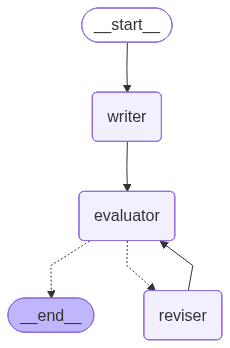

In [17]:
graph

In [18]:
# 5️⃣ Run reflection loop
result = graph.invoke({"topic": "Write a creative story on Universe focusing on possibilities of distant life. Make the story progressive and compact."}, config=config)
print("\n🔁 Final Improved Draft:\n", result["draft"])
print("\n🧠 Evaluator Feedback:\n", result["feedback"])


🧠 Evaluator Score: 8/10

🔁 Final Improved Draft:
 In the swirling shadows of the cosmos, a small, unremarkable blue planet named Earth spun on its axis, nestled in the arms of the Milky Way. As the sun rose on its eastern horizon, a young astrobiologist named Mia peered through her telescope, marveling at the swirling nebulae and distant stars. Her heart raced with the possibilities of life beyond her own planet.

For years, Mia studied signals from space, sifting through electromagnetic waves for any trace of intelligent life. Her colleagues often dismissed her obsession, but she was fueled by an insatiable curiosity and a star-studded dream that life existed out there, waiting to be discovered. 

One crisp autumn night, just as the first leaves turned to gold, she detected an anomaly—a series of rhythmic pulses echoing from Proxima Centauri. The signals were too structured to be random noise. It was an invitation, a beacon from a distant world. 

Driven by her intuition, Mia crafted